In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
    
train_transforms = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=train_transforms, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim,hidden_dim = 128):
        super(Generator, self).__init__()
        self.fc1 = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU()
        )
        self.fc2 = nn.Sequential(
        nn.Linear(hidden_dim, 2*hidden_dim),
        nn.BatchNorm1d(2 * hidden_dim),
        nn.ReLU()
        )
        self.fc3 = nn.Sequential(
        nn.Linear(2 * hidden_dim, 4 * hidden_dim),
        nn.BatchNorm1d(4 * hidden_dim),
        nn.ReLU()
        )
        self.fc4 = nn.Sequential(
        nn.Linear(4 * hidden_dim, 8 * hidden_dim),
        nn.BatchNorm1d(8 * hidden_dim),
        nn.ReLU()
        )
        self.fc5 = nn.Sequential(
        nn.Linear(8 * hidden_dim, 8 * hidden_dim),
        nn.BatchNorm1d(8 * hidden_dim),
        nn.ReLU()
        )
        self.final = nn.Sequential(
        nn.Linear(8 * hidden_dim, output_dim),
        )


    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = torch.tanh(self.final(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
    
        x = torch.sigmoid(self.fc4(x))
        return x

# Example usage:
# Assuming input_dim for generator is 100 (latent space dimension)
# and output_dim is the size of the generated image (e.g., 28*28 for MNIST)
generator = Generator(input_dim=100, output_dim=28*28)
discriminator = Discriminator(input_dim=28*28)

D Loss: 0.8589, G Loss: 3.8418


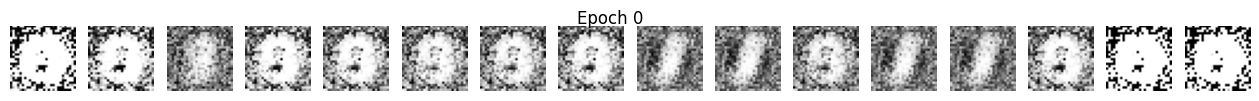

D Loss: 0.5624, G Loss: 5.2090


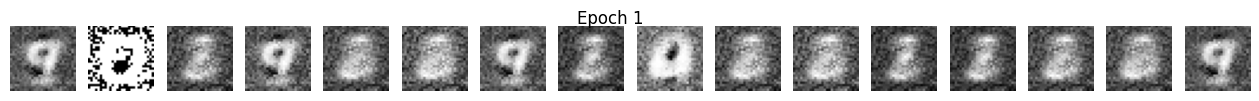

D Loss: 0.8103, G Loss: 3.4586


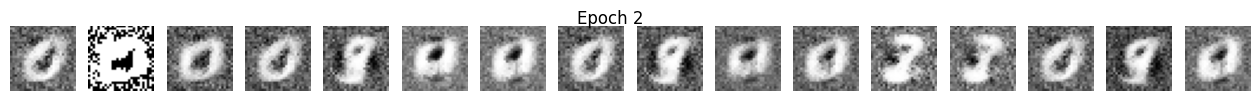

D Loss: 0.7505, G Loss: 2.3322


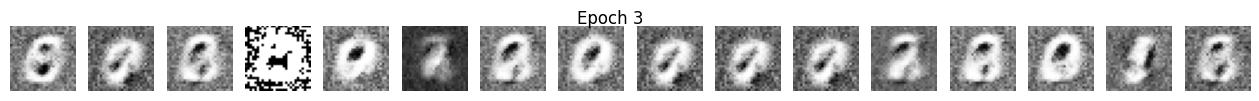

D Loss: 0.8484, G Loss: 1.9692


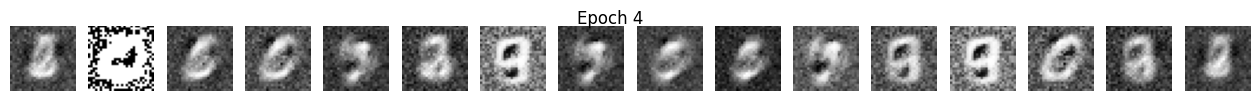

D Loss: 0.8785, G Loss: 1.7902


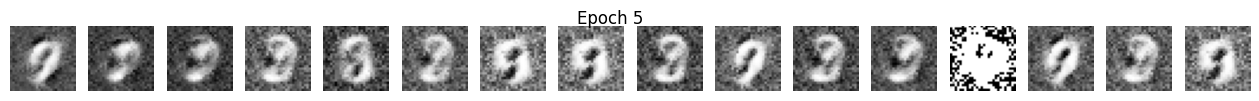

D Loss: 0.9377, G Loss: 1.5692


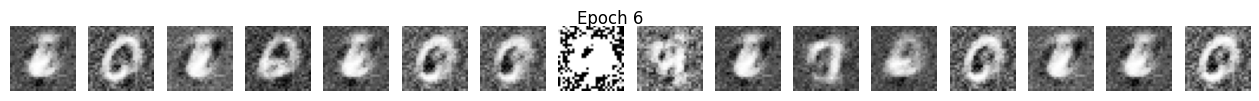

D Loss: 1.0391, G Loss: 1.3110


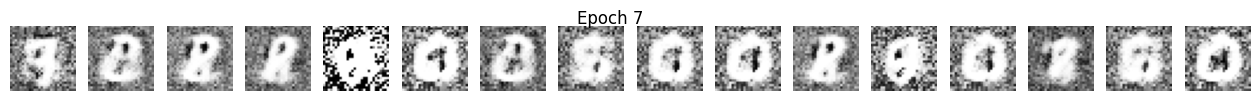

D Loss: 1.0674, G Loss: 1.1995


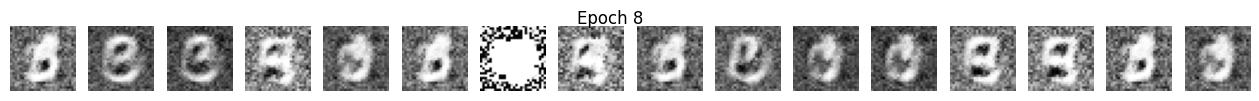

D Loss: 1.0002, G Loss: 1.2935


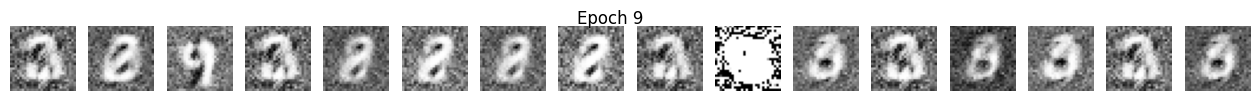

D Loss: 1.1323, G Loss: 1.1342


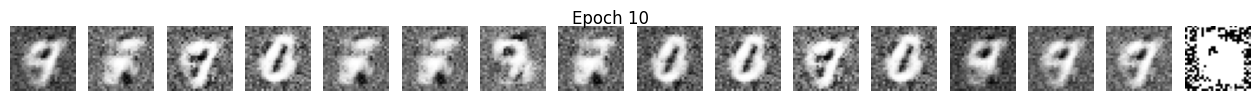

D Loss: 1.0244, G Loss: 1.2407


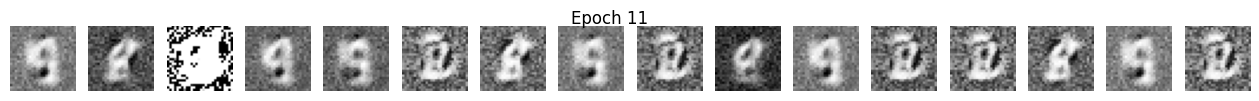

D Loss: 0.9925, G Loss: 1.2753


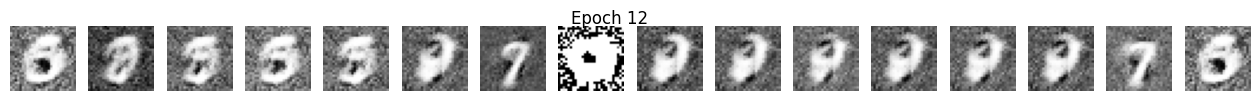

D Loss: 1.0028, G Loss: 1.2826


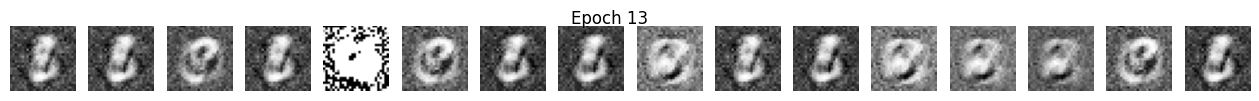

D Loss: 0.9319, G Loss: 1.4171


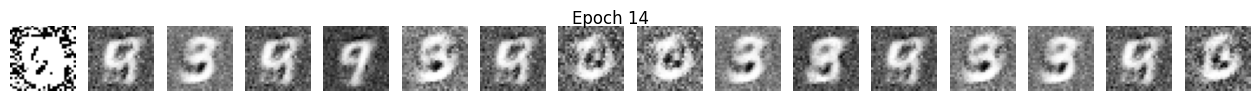

In [11]:
CUDA_LAUNCH_BLOCKING=1
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

def show_generated_images(generator, epoch, latent_dim, num_images=16):
    # Generate random noise
    z = torch.randn(num_images, latent_dim).to(device)
    # Generate images
    with torch.no_grad():
        generated_images = generator(z)
    # Reshape and denormalize images
    generated_images = generated_images.detach().cpu().view(num_images, 1, 28, 28)
    generated_images = generated_images * 0.5 + 0.5  # Rescale to [0, 1]

    # Plot images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(generated_images[i,0].numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# Hyperparameters
batch_size = 64
learning_rate = 0.0002
num_epochs = 15
latent_dim = 100
image_size = 28 * 28  # For MNIST


# Initialize models
generator = Generator(input_dim=latent_dim, output_dim=image_size).to(device)
discriminator = Discriminator(input_dim=image_size).to(device)

# Loss and optimizers
criterion = nn.BCELoss().to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)
k = 2
# Training loop
for epoch in range(num_epochs):
    total_d_loss = 0
    total_g_loss = 0
    discriminator.train()
    generator.train()
    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        labels_real = torch.ones((batch_size,1)).to(device)
        labels_fake = torch.zeros((batch_size,1)).to(device)
            
        for _ in range(k):
            
            real_images = real_images.view(batch_size, -1).to(device)
            
            # Train Discriminator
            optimizer_d.zero_grad()
    
            # Real images
            real_outputs = discriminator(real_images)
             # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            
            d_loss = criterion(real_outputs,labels_real) + criterion(fake_outputs, labels_fake)
            d_loss.backward()
            optimizer_d.step()
        
        total_d_loss += d_loss.item()
        
        # Train Generator
        optimizer_g.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, labels_real) 
        g_loss.backward()
    
        optimizer_g.step()
        total_g_loss += g_loss.item()
    

    print(f'D Loss: {total_d_loss/len(train_loader):.4f}, G Loss: {total_g_loss/len(train_loader):.4f}')
    
    show_generated_images(generator, epoch, latent_dim)
